In [156]:
# from google.colab import drive
# drive.mount('/content/drive')

In [157]:
# !pip install opencv-python-headless
# !pip install pytesseract
# !pip install numpy
# !pip install pandas
!pip install streamlit


In [158]:
#Environment Setup
!pip install opencv-python-headless pytesseract numpy pandas

# Load libraries
import cv2
import pytesseract
import numpy as np
import pandas as pd
import streamlit as st
import os
from PIL import Image


In [159]:
!pip install ultralytics



0: 288x640 1 license_plate, 80.5ms
Speed: 6.1ms preprocess, 80.5ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)


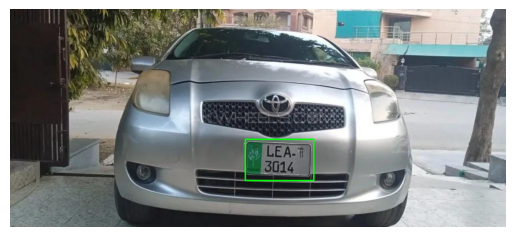

In [160]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load YOLOv8 model
def load_yolo_model():
    model = YOLO('/kaggle/input/liscence/license_plate_detector.pt')  # Load your model
    return model

# License plate detection function
def detect_license_plate(image_path):
    # Load image
    image = cv2.imread(image_path)
    
    # Load YOLO model
    model = load_yolo_model()
    
    # Run YOLOv8 inference
    results = model(image)
    
    # Draw rectangles around detected license plates
    for result in results:
        for box in result.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Draw a rectangle around the detected license plate
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green rectangle with thickness 2
            
    # Display the image with rectangles using Matplotlib
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example usage
image_path = "/kaggle/input/images/toyota-vitz-2007-96143950.jpg"  # Replace with your image path
detect_license_plate(image_path)



0: 288x640 1 license_plate, 71.6ms
Speed: 2.6ms preprocess, 71.6ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


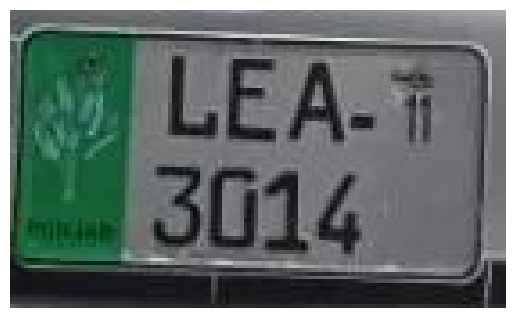

array([[[107, 102, 101],
        [107, 102,  99],
        [106, 102,  97],
        ...,
        [167, 167, 167],
        [168, 168, 168],
        [169, 169, 169]],

       [[106, 101, 100],
        [106, 101,  98],
        [106, 102,  97],
        ...,
        [161, 161, 161],
        [162, 162, 162],
        [162, 162, 162]],

       [[105, 101, 100],
        [109, 106, 102],
        [ 96,  93,  88],
        ...,
        [153, 153, 153],
        [154, 154, 154],
        [154, 154, 154]],

       ...,

       [[ 52,  47,  48],
        [ 52,  47,  48],
        [ 51,  46,  47],
        ...,
        [ 34,  30,  29],
        [ 34,  30,  29],
        [ 31,  27,  26]],

       [[ 62,  57,  58],
        [ 62,  57,  58],
        [ 62,  57,  58],
        ...,
        [ 34,  30,  29],
        [ 34,  30,  29],
        [ 31,  27,  26]],

       [[ 97,  92,  93],
        [ 90,  85,  86],
        [ 83,  78,  79],
        ...,
        [ 47,  43,  42],
        [ 47,  43,  42],
        [ 48,  44,  43]]

In [161]:


# License plate detection function
def detect_and_crop_license_plate(image_path):
    # Load image
    image = cv2.imread(image_path)
    
    # Load YOLO model
    model = load_yolo_model()
    
    # Run YOLOv8 inference
    results = model(image)
    
    # Extract the bounding boxes for the detected objects
    for result in results:
        for box in result.boxes:
            # Get bounding box coordinates
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            # Crop the detected license plate area
            cropped_license_plate = image[y1:y2, x1:x2]
            
            # Display the cropped license plate using Matplotlib
            plt.imshow(cv2.cvtColor(cropped_license_plate, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
    
    return cropped_license_plate

# Example usage
detect_and_crop_license_plate(image_path)


In [162]:
import statistics as st  # Import the statistics module

# helper function for countors identification
def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    img_res = []
    widths = []
    heights = []
    contours = []  # Store contour coordinates here

    # Calculate the middle line of the license plate
    middle_line = img.shape[0] // 2

    # Sort contours based on x-coordinate and then on y-coordinate
    sorted_cntrs = sorted(cntrs, key=lambda c: (c[0][0][0], c[0][0][1]))

    # Separate contours above and below the middle line
    above_middle = []
    below_middle = []
    for cntr in sorted_cntrs:
        x, y, w, h = cv2.boundingRect(cntr)

        if y < middle_line:
            above_middle.append((x, y, w, h, cntr))
        else:
            below_middle.append((x, y, w, h, cntr))

    # Sort contours from left to right
    above_middle = sorted(above_middle, key=lambda c: c[0])
    below_middle = sorted(below_middle, key=lambda c: c[0])

    # Process contours above the middle line
    for x, y, w, h, cntr in above_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates
                print(f"Added width: {w}, height: {h}")  # Debugging line
                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Process contours below the middle line
    for x, y, w, h, cntr in below_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates
                print(f"Added width: {w}, height: {h}")  # Debugging line
                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)
    for x, y, w, h, cntr in above_middle + below_middle:
        cv2.rectangle(ii, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Draw contours in green

    plt.imshow(ii, cmap='gray')
    plt.title("Detected Contours")
    plt.show()

    # Visualize the segmented characters
    for i, char_img in enumerate(img_res):
        plt.subplot(1, len(img_res), i + 1)
        plt.imshow(char_img, cmap='gray')
        plt.axis('off')
    plt.title("Segmented Characters")
    plt.show()
    # Calculate median width and height
    # Calculate median width and height if lists are not empty
    if widths and heights:
        median_width = st.median(widths)
        median_height = st.median(heights)
    else:
        print("No valid character contours detected. Skipping median calculation.")
        median_width = 0
        median_height = 0


    # Filter characters based on width and height deviation from the median
    filtered_img_res = []
    filtered_contours = []
    for char, contour in zip(img_res, contours):
        x1, y1, x2, y2 = contour
        if ((x2 - x1) >= 0.70 * median_width) and ((x2 - x1) <= 1.3 * median_width) and ((y2 - y1) >= 0.70 * median_height) and ((y2 - y1) <= 1.3 * median_height):
            filtered_img_res.append(char)
            filtered_contours.append(contour)

    # Remove contours with a distance of more than 15 pixels between them
    remaining_contours = []
    remaining_filtered_img_res = []
    if len(filtered_contours) > 1:
        center_x = img.shape[1] / 3
        distance = 0
        count = 1
        for i in range(1, len(filtered_contours)):
            if count >= len(filtered_contours):
                break
            x1_prev, _, x2_prev, _ = filtered_contours[count - 1]
            x1_curr, _, x2_curr, _ = filtered_contours[count]
            distance = x1_curr - x2_prev
            print (f"Distance between contours {count} and {count+1}: {distance}")
            if distance <= -175:
                count += 1
                continue
            elif 0 < distance <= 15:
                print("if (distance <= 15):")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1
            elif x1_curr < center_x:
                print("elif x1_curr < center_x:")
                remaining_contours.append(filtered_contours[count])
                remaining_filtered_img_res.append(filtered_img_res[count])
                count +=2
            elif x1_curr >= (center_x * 2):
                print("elif x1_curr >= center_x:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count +=2
            else:
                print("else:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1

        print("Last contour")
        remaining_contours.append(filtered_contours[-1])
        remaining_filtered_img_res.append(filtered_img_res[-1])
        # After finding contours
    print(f"Number of contours detected: {len(cntrs)}")

    plt.show()

    return np.array(remaining_filtered_img_res)


In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segment_characters(image):
    # Resize the image to a standard size
    image = cv2.resize(image, (333, 75))  # You can adjust this size based on your license plate size
    
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply binary thresholding
    _, img_binary_lp = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply some morphological operations to remove noise
    kernel = np.ones((3,3), np.uint8)
    img_binary_lp = cv2.morphologyEx(img_binary_lp, cv2.MORPH_CLOSE, kernel)
    
    # White out the borders of the image to avoid detecting them as contours
    img_binary_lp[0:3, :] = 255
    img_binary_lp[:, 0:3] = 255
    img_binary_lp[72:75, :] = 255
    img_binary_lp[:, 330:333] = 255
    
    # Dimensions for contour estimation (based on typical character sizes on license plates)
    LP_WIDTH = image.shape[1]
    LP_HEIGHT = image.shape[0]
    dimensions = [LP_WIDTH/10, 2*LP_WIDTH/2.5, LP_HEIGHT/20, 2*LP_HEIGHT/2.5]
    
    # Show the processed image (optional)
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    
    # Save the binary image for debugging (optional)
    cv2.imwrite('contour.jpg', img_binary_lp)
    
    # Find character contours within the cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)
    
    return char_list



0: 288x640 1 license_plate, 75.1ms
Speed: 2.5ms preprocess, 75.1ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


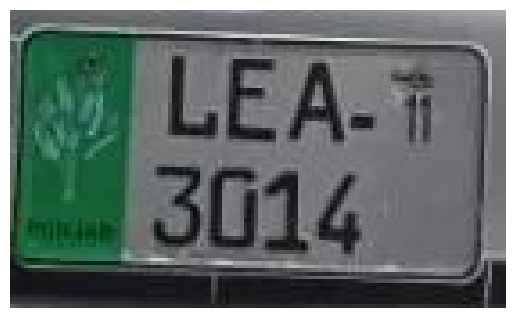

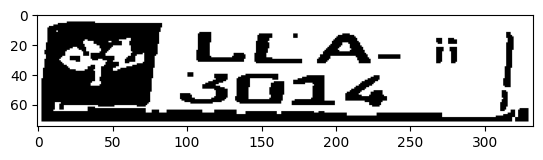

Added width: 35, height: 22
Added width: 34, height: 22
Added width: 38, height: 22
Added width: 34, height: 22
Added width: 35, height: 22


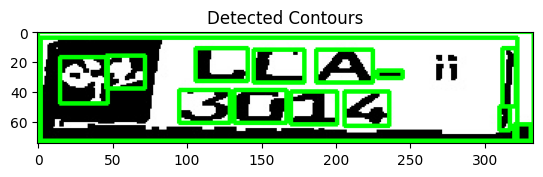

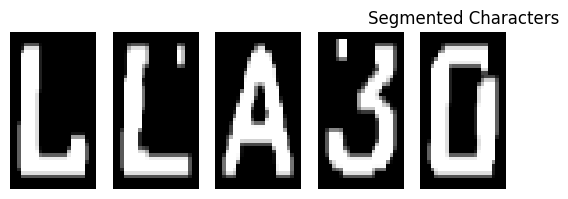

Distance between contours 1 and 2: 4
if (distance <= 15):
Distance between contours 2 and 3: 8
if (distance <= 15):
Distance between contours 3 and 4: -130
elif x1_curr < center_x:
Last contour
Number of contours detected: 15


array([[[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0]],

       [[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,        

In [164]:
#Test the function
# Reading cropped license plate image
crop_lp = detect_and_crop_license_plate(image_path)

char = segment_characters(crop_lp)
char

In [165]:
import torch
import torch.nn as nn

# Define the convolutional neural network model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Adjusted to 16 filters
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Adjusted to 32 filters
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Adjusted to 64 units
        self.fc2 = nn.Linear(64, 36)  # 36 classes: 0-9 and A-Z
        
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))

        # Change from view() to reshape() to handle non-contiguous tensors
        x = x.reshape(-1, 32 * 7 * 7)  # Flatten with 32 filters

        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, move it to the selected device
model = CNNNet().to(device)


In [166]:
# Initialize the model

 # Ensure to define your model class again

# Load the model's state dictionary

# Set the model to evaluation mode (if you're going to evaluate it)
import torch

def load_cnn_model():
    model = CNNNet()  # Ensure CNNNet is defined
    model.load_state_dict(torch.load('/kaggle/input/cnn/pytorch/default/1/cnn_model_part1.pth'))  # Load saved model weights
    model.eval()  # Set the model to evaluation mode
    return model

# Initialize the model
model = load_cnn_model().to(device)  # Load model and move to device



In [167]:
import numpy as np
import cv2
import torch

# Preprocess input image for character prediction
def fix_dimension(img):
    # Resizing the image to (28, 28) if not already of this size
    if img.shape[:2] != (28, 28):
        img = cv2.resize(img, (28, 28))
    
    # If the image is (28, 28), add a new dimension to make it (28, 28, 1) for grayscale
    if len(img.shape) == 2:  # If it's 2D (grayscale), add channel dimension
        img = np.expand_dims(img, axis=-1)
    
    return img



def show_results(characters, char):
    dic = {i: c for i, c in enumerate(characters)}  # Mapping of indices to characters
    
    output = []
    for i, ch in enumerate(char):  # Iterating over the list of character images
        # Resize and fix dimension of each image
        ch = fix_dimension(ch)

        # Preparing the image for the model (convert to PyTorch tensor)
        ch = np.expand_dims(ch, axis=0)  # Add batch dimension (1, 28, 28, 1)
        ch = np.transpose(ch, (0, 3, 1, 2))  # Convert to PyTorch format (N, C, H, W)
        
        ch_tensor = torch.tensor(ch, dtype=torch.float32).to(device)  # Convert to tensor and send to device

        # Normalize the image to [0, 1]
        ch_tensor /= 255.0

        # Inference: no need to track gradients
        with torch.no_grad():
            # Forward pass: get prediction
            prediction = model(ch_tensor)
            pred_class = torch.argmax(prediction, dim=1).item()  # Get the index of the predicted class

        # Append the predicted character to the output list
        output.append(dic[pred_class])

    # Join the predicted characters into a string
    plate_number = ''.join(output)

    return plate_number


# Example characters to predict
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# Assume `char` is a list of character images (each image is a numpy array)
lp_number = show_results(characters, char)
print(lp_number)


LEMD



0: 608x640 1 license_plate, 144.4ms
Speed: 4.1ms preprocess, 144.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


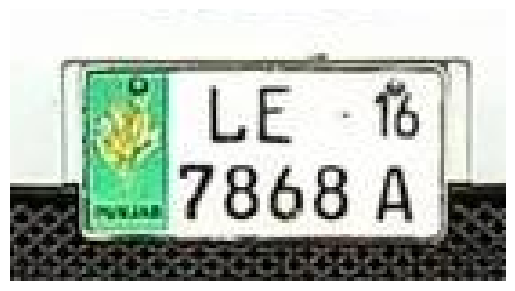

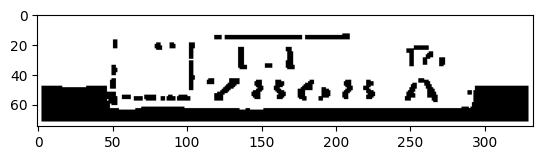

Added width: 54, height: 5


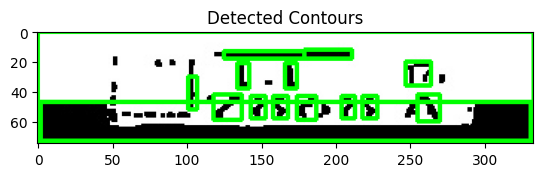

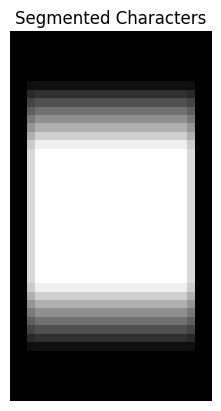

Number of contours detected: 15


0: 608x640 1 license_plate, 135.6ms
Speed: 3.7ms preprocess, 135.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


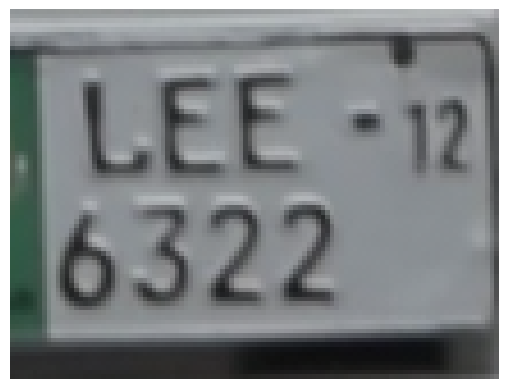

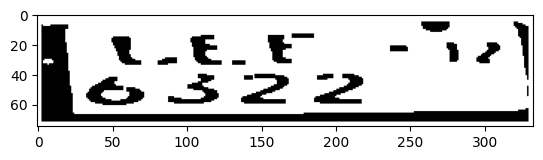

Added width: 41, height: 21
Added width: 36, height: 22
Added width: 34, height: 22
Added width: 35, height: 22


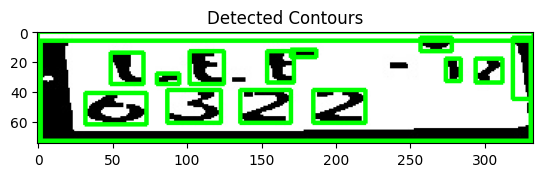

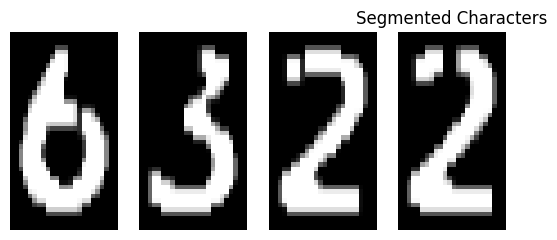

Distance between contours 1 and 2: 14
if (distance <= 15):
Distance between contours 2 and 3: 13
if (distance <= 15):
Distance between contours 3 and 4: 15
if (distance <= 15):
Last contour
Number of contours detected: 15
6322

0: 640x384 1 license_plate, 94.8ms
Speed: 2.7ms preprocess, 94.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


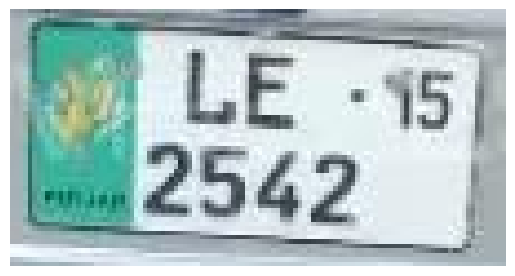

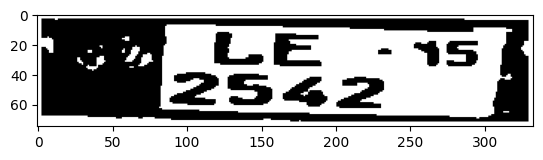

Added width: 35, height: 24
Added width: 34, height: 24
Added width: 35, height: 24
Added width: 34, height: 23


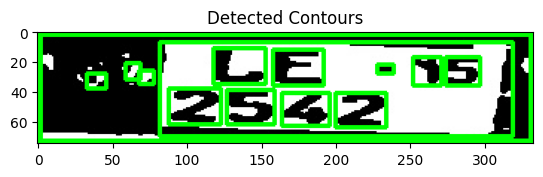

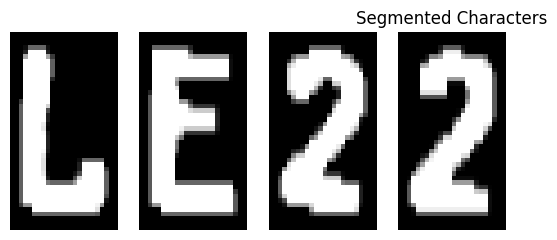

Distance between contours 1 and 2: 5
if (distance <= 15):
Distance between contours 2 and 3: -104
elif x1_curr < center_x:
Last contour
Number of contours detected: 15
L22

0: 288x640 1 license_plate, 73.7ms
Speed: 2.1ms preprocess, 73.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


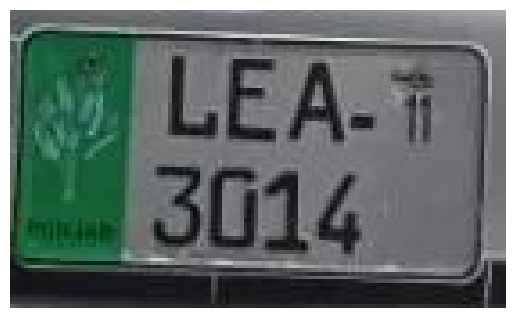

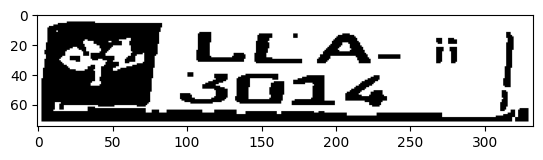

Added width: 35, height: 22
Added width: 34, height: 22
Added width: 38, height: 22
Added width: 34, height: 22
Added width: 35, height: 22


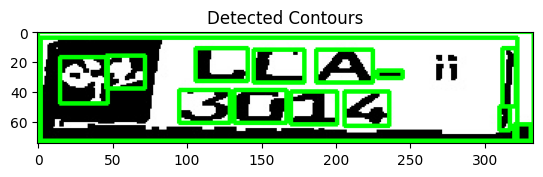

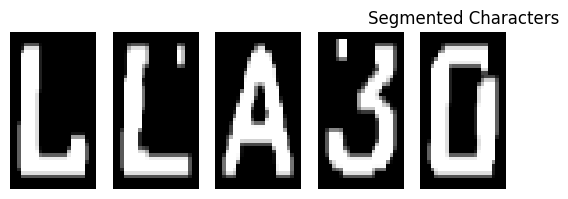

Distance between contours 1 and 2: 4
if (distance <= 15):
Distance between contours 2 and 3: 8
if (distance <= 15):
Distance between contours 3 and 4: -130
elif x1_curr < center_x:
Last contour
Number of contours detected: 15
LEMD

0: 288x640 1 license_plate, 104.5ms
Speed: 2.5ms preprocess, 104.5ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


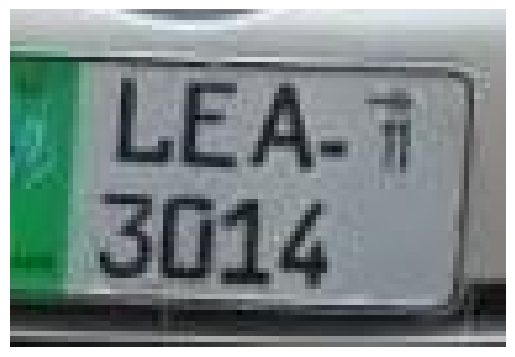

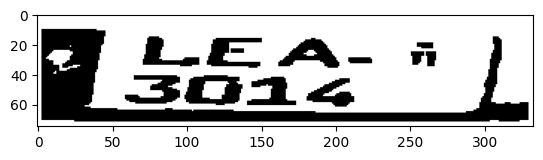

Added width: 40, height: 22
Added width: 39, height: 22
Added width: 43, height: 22
Added width: 39, height: 21
Added width: 41, height: 22
Added width: 35, height: 21
Added width: 34, height: 21


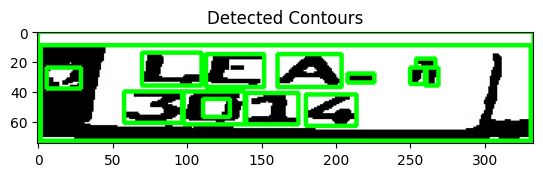

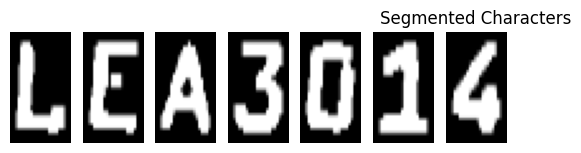

Distance between contours 1 and 2: 3
if (distance <= 15):
Distance between contours 2 and 3: 9
if (distance <= 15):
Distance between contours 3 and 4: -146
elif x1_curr < center_x:
Distance between contours 5 and 6: 1
if (distance <= 15):
Distance between contours 6 and 7: 5
if (distance <= 15):
Last contour
Number of contours detected: 15
LEJM14

0: 576x640 1 license_plate, 137.0ms
Speed: 4.6ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


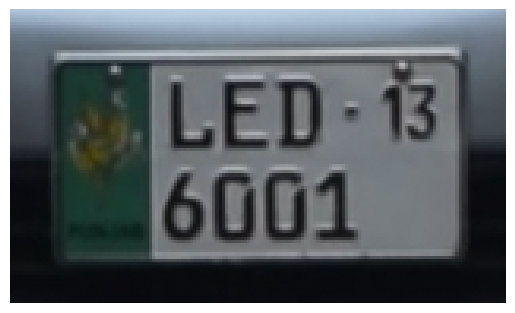

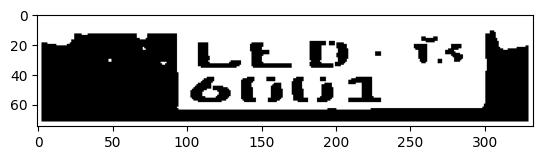

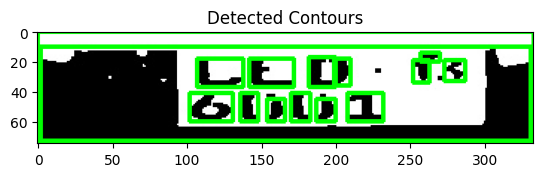

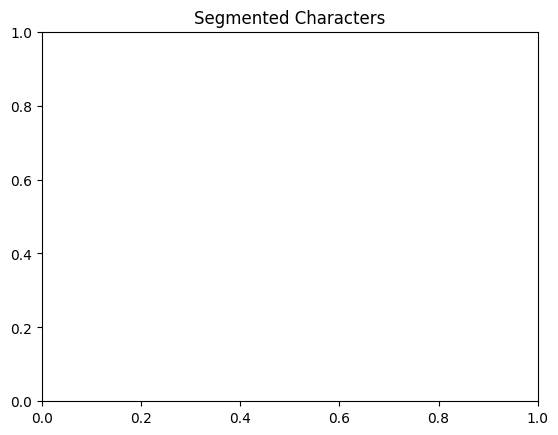

No valid character contours detected. Skipping median calculation.
Number of contours detected: 15


0: 640x288 1 license_plate, 74.1ms
Speed: 2.4ms preprocess, 74.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 288)


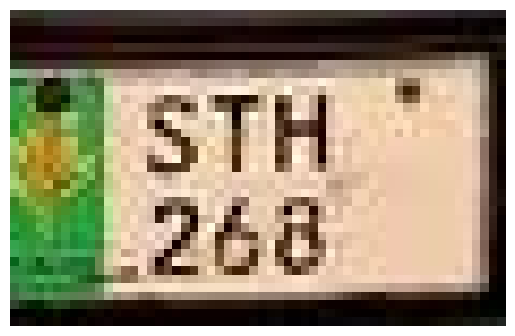

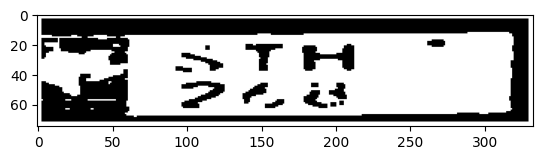

Added width: 37, height: 20


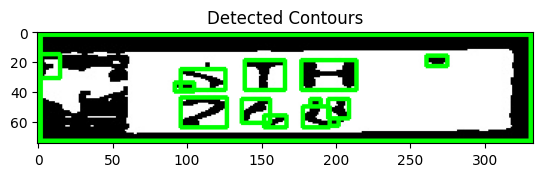

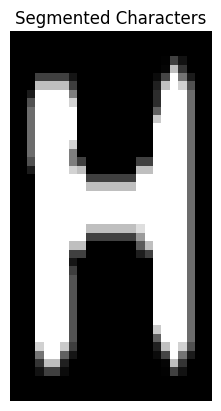

Number of contours detected: 15


0: 480x640 1 license_plate, 109.3ms
Speed: 2.7ms preprocess, 109.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


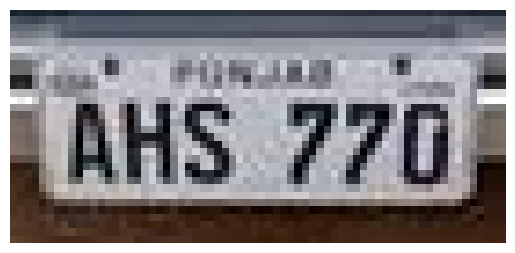

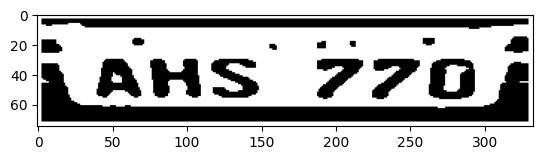

Added width: 36, height: 28
Added width: 34, height: 28
Added width: 34, height: 29


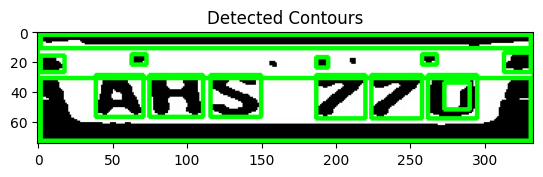

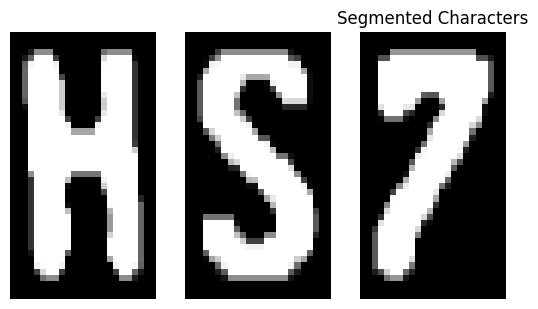

Distance between contours 1 and 2: 5
if (distance <= 15):
Distance between contours 2 and 3: 74
elif x1_curr >= center_x:
Last contour
Number of contours detected: 15
MMI

0: 608x640 1 license_plate, 136.8ms
Speed: 3.7ms preprocess, 136.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


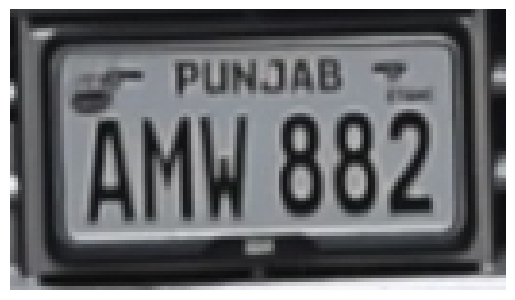

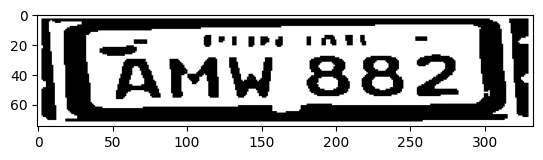

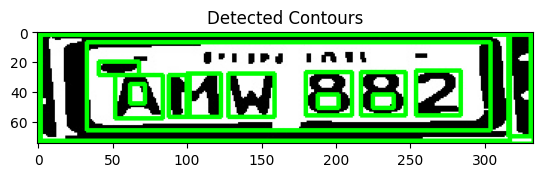

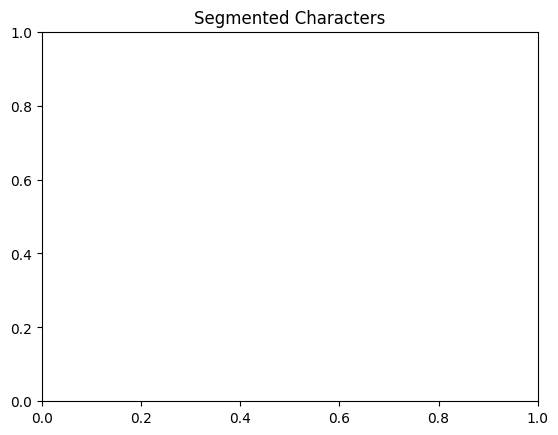

No valid character contours detected. Skipping median calculation.
Number of contours detected: 15



In [171]:
import os
import cv2
import torch
import numpy as np
import csv
from datetime import datetime
from ultralytics import YOLO

# Function to load YOLO model


# Function to detect and crop license plate using YOLO



# Function to load CNN model
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 36)
        
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = x.reshape(-1, 32 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

def load_cnn_model(model_path):
    model = CNNNet()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Function to preprocess character images
# Function to preprocess character images
def preprocess_characters(characters):
    processed_characters = []
    for char in characters:
        # Resize character images to (28, 28) if not already of this size
        char_resized = cv2.resize(char, (28, 28))
        
        # If the image is grayscale, add a new dimension to make it (1, 28, 28)
        if len(char_resized.shape) == 2:  # If it's 2D (grayscale)
            char_resized = np.expand_dims(char_resized, axis=0)  # Add channel dimension
        else:
            char_resized = np.transpose(char_resized, (2, 0, 1))  # Convert from (H, W, C) to (C, H, W)

        processed_characters.append(char_resized)

    # Convert list of character images to tensor
    processed_characters = np.array(processed_characters)  # Convert to numpy array
    processed_characters = torch.tensor(processed_characters, dtype=torch.float32)  # Convert to tensor
    processed_characters = processed_characters.to(device)  # Move to the correct device
    return processed_characters

# Function to predict license plate characters
def predict_characters(model, characters):
    characters = preprocess_characters(characters)
    with torch.no_grad():
        predictions = model(characters)
        predicted_classes = torch.argmax(predictions, dim=1)
    return predicted_classes


# Function to generate database entry
def generate_database_entry(license_plate_number, image_label):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    entry = {
        "License Plate Number": license_plate_number,
        "Image Label": image_label,
        "Timestamp": timestamp
    }
    return entry

# Function to write database entries to CSV
def write_to_csv(database_entries, csv_filename):
    with open(csv_filename, mode='w', newline='') as file:
        fieldnames = ['License Plate Number', 'Image Label', 'Timestamp']
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for entry in database_entries:
            writer.writerow(entry)

# Main script
if __name__ == "__main__":
    # Define paths and directories
    images_directory = '/kaggle/input/images'
    cnn_model_path = '/kaggle/input/cnn/pytorch/default/1/cnn_model_part1.pth'
    csv_filename = 'license_plate_logs.csv'

   
    
    # Load CNN model
    cnn_model = load_cnn_model(cnn_model_path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cnn_model.to(device)
    
    # List to store database entries
    database_entries = []

    # Process each image in the directory
    for image_filename in os.listdir(images_directory):
        if image_filename.endswith(".jpg") or image_filename.endswith(".png"):
            image_path = os.path.join(images_directory, image_filename)
            
            # Step 2: Detect and crop license plate
            
            # Step 3: Segment characters
            model = YOLO('/kaggle/input/liscence/license_plate_detector.pt')  # Load your model
            char_list = segment_characters(detect_and_crop_license_plate(image_path))
            ##############################################
            
            
            
            
            # Step 4: Predict characters using CNN
#             predicted_characters = predict_characters(cnn_model, char_list)
            import torch
            import torch.nn as nn

            # Define the convolutional neural network model
            class CNNNet(nn.Module):
                def __init__(self):
                    super(CNNNet, self).__init__()
                    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Adjusted to 16 filters
                    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Adjusted to 32 filters
                    self.pool = nn.MaxPool2d(2, 2)
                    self.fc1 = nn.Linear(32 * 7 * 7, 64)  # Adjusted to 64 units
                    self.fc2 = nn.Linear(64, 36)  # 36 classes: 0-9 and A-Z

                def forward(self, x):
                    x = self.pool(nn.ReLU()(self.conv1(x)))
                    x = self.pool(nn.ReLU()(self.conv2(x)))

                    # Change from view() to reshape() to handle non-contiguous tensors
                    x = x.reshape(-1, 32 * 7 * 7)  # Flatten with 32 filters

                    x = nn.ReLU()(self.fc1(x))
                    x = self.fc2(x)
                    return x

            # Set the device
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            # Initialize the model, move it to the selected device
            model = CNNNet().to(device)
            import torch

            def load_cnn_model():
                model = CNNNet()  # Ensure CNNNet is defined
                model.load_state_dict(torch.load('/kaggle/input/cnn/pytorch/default/1/cnn_model_part1.pth'))  # Load saved model weights
                model.eval()  # Set the model to evaluation mode
                return model

            # Initialize the model
            model = load_cnn_model().to(device)  # Load model and move to device
            import numpy as np
            import cv2
            import torch

            # Preprocess input image for character prediction
            def fix_dimension(img):
                # Resizing the image to (28, 28) if not already of this size
                if img.shape[:2] != (28, 28):
                    img = cv2.resize(img, (28, 28))

                # If the image is (28, 28), add a new dimension to make it (28, 28, 1) for grayscale
                if len(img.shape) == 2:  # If it's 2D (grayscale), add channel dimension
                    img = np.expand_dims(img, axis=-1)

                return img



            def show_results(characters, char):
                dic = {i: c for i, c in enumerate(characters)}  # Mapping of indices to characters

                output = []
                for i, ch in enumerate(char):  # Iterating over the list of character images
                    # Resize and fix dimension of each image
                    ch = fix_dimension(ch)

                    # Preparing the image for the model (convert to PyTorch tensor)
                    ch = np.expand_dims(ch, axis=0)  # Add batch dimension (1, 28, 28, 1)
                    ch = np.transpose(ch, (0, 3, 1, 2))  # Convert to PyTorch format (N, C, H, W)

                    ch_tensor = torch.tensor(ch, dtype=torch.float32).to(device)  # Convert to tensor and send to device

                    # Normalize the image to [0, 1]
                    ch_tensor /= 255.0

                    # Inference: no need to track gradients
                    with torch.no_grad():
                        # Forward pass: get prediction
                        prediction = model(ch_tensor)
                        pred_class = torch.argmax(prediction, dim=1).item()  # Get the index of the predicted class

                    # Append the predicted character to the output list
                    output.append(dic[pred_class])

                # Join the predicted characters into a string
                plate_number = ''.join(output)

                return plate_number


            # Example characters to predict
            characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
            # Assume `char` is a list of character images (each image is a numpy array)
            license_plate_number = show_results(characters, char_list)
            print(license_plate_number)

            # Step 5: Convert predictions to license plate number
            
            # Step 6: Generate database entry
            entry = generate_database_entry(license_plate_number, image_filename)
            database_entries.append(entry)
    
    # Step 7: Write database entries to CSV
    write_to_csv(database_entries, csv_filename)

